## Library

In [1]:
# Data Preprocessing and Preparation
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import time

2024-12-22 22:45:17.975456: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 22:45:18.018351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 22:45:18.105271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-22 22:45:18.107066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-22 22:48:50.481144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Data preparation

In [2]:
df = yf.download('PTT.BK', start="2019-07-01", end="2024-06-30")
df.index = pd.to_datetime(df.index)
df.columns = df.columns.droplevel(1)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-07-01 00:00:00+00:00,38.007935,49.50,49.50,49.0,49.50,52067800
2019-07-02 00:00:00+00:00,37.240093,48.50,49.50,48.5,49.25,51490800
2019-07-03 00:00:00+00:00,37.048141,48.25,48.50,48.0,48.50,44524800
2019-07-04 00:00:00+00:00,37.048141,48.25,48.75,48.0,48.50,49509400
2019-07-05 00:00:00+00:00,37.048141,48.25,48.50,48.0,48.25,20907100


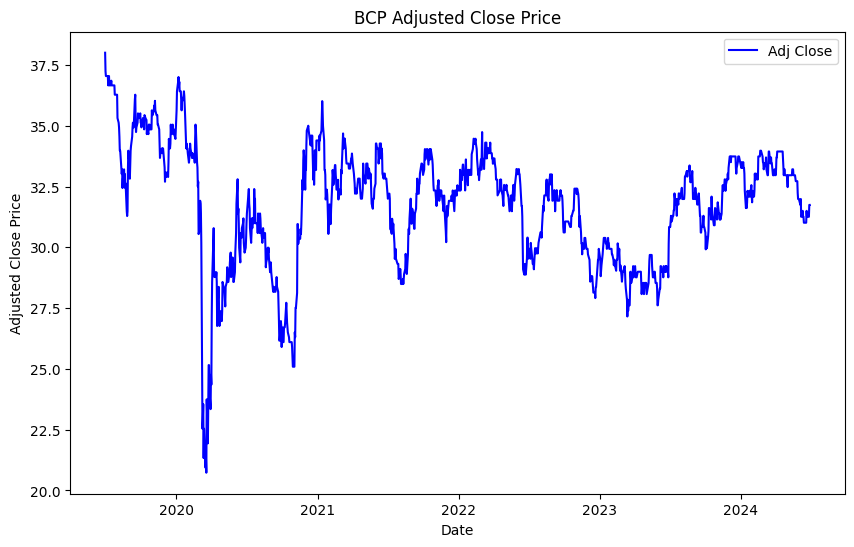

In [3]:
import matplotlib.pyplot as plt

# สมมติว่าคุณมี DataFrame ที่ชื่อว่า dataset ที่มีคอลัมน์ 'Adj Close' และ index เป็น datetime
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='blue')

# ตั้งชื่อกราฟ
plt.title('BCP Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

# แสดง legend และ plot
plt.legend()
plt.show()


In [4]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
df = df.drop('Close',axis=1)
dataset = df
values = dataset.values
values = values.astype('float32')


# ทำ scaling ข้อมูลด้วยวิธี min-max normalized scaling เปลี่ยน scale ข้อมูลแต่ละ column และเก็บค่า mean และ sd แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())


# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 15, 31,feat_name=df.columns)
# แก้ไขจากการ drop คอลัมน์ตั้งแต่ t ถึง t-6 เป็น t ถึง t-29
reframed.drop(['High(t+1)', 'High(t+2)', 'High(t+3)', 'High(t+4)', 'High(t+5)', 'High(t+6)', 'High(t+7)', \
               'High(t+8)', 'High(t+9)', 'High(t+10)', 'High(t+11)', 'High(t+12)', 'High(t+13)', 'High(t+14)', \
               'High(t+15)', 'High(t+16)', 'High(t+17)', 'High(t+18)', 'High(t+19)', 'High(t+20)', 'High(t+21)', \
               'High(t+22)', 'High(t+23)', 'High(t+24)', 'High(t+25)', 'High(t+26)', 'High(t+27)', 'High(t+28)', 'High(t+29)','High(t+30)',\
               'Low(t+1)', 'Low(t+2)', 'Low(t+3)', 'Low(t+4)', 'Low(t+5)', 'Low(t+6)', 'Low(t+7)', \
               'Low(t+8)', 'Low(t+9)', 'Low(t+10)', 'Low(t+11)', 'Low(t+12)', 'Low(t+13)', 'Low(t+14)', \
               'Low(t+15)', 'Low(t+16)', 'Low(t+17)', 'Low(t+18)', 'Low(t+19)', 'Low(t+20)', 'Low(t+21)', \
               'Low(t+22)', 'Low(t+23)', 'Low(t+24)', 'Low(t+25)', 'Low(t+26)', 'Low(t+27)', 'Low(t+28)', 'Low(t+29)','Low(t+30)',\
               'Open(t+1)', 'Open(t+2)', 'Open(t+3)', 'Open(t+4)', 'Open(t+5)', 'Open(t+6)', 'Open(t+7)', 
               'Open(t+8)', 'Open(t+9)', 'Open(t+10)', 'Open(t+11)', 'Open(t+12)', 'Open(t+13)', 'Open(t+14)', \
               'Open(t+15)', 'Open(t+16)', 'Open(t+17)', 'Open(t+18)', 'Open(t+19)', 'Open(t+20)', 'Open(t+21)', \
               'Open(t+22)', 'Open(t+23)', 'Open(t+24)', 'Open(t+25)', 'Open(t+26)', 'Open(t+27)', 'Open(t+28)', 'Open(t+29)','Open(t+30)',\
               'Volume(t+1)', 'Volume(t+2)', 'Volume(t+3)', 'Volume(t+4)', 'Volume(t+5)', 'Volume(t+6)', 'Volume(t+7)', \
               'Volume(t+8)', 'Volume(t+9)', 'Volume(t+10)', 'Volume(t+11)', 'Volume(t+12)', 'Volume(t+13)', 'Volume(t+14)', \
               'Volume(t+15)', 'Volume(t+16)', 'Volume(t+17)', 'Volume(t+18)', 'Volume(t+19)', 'Volume(t+20)', 'Volume(t+21)', \
               'Volume(t+22)', 'Volume(t+23)', 'Volume(t+24)', 'Volume(t+25)', 'Volume(t+26)', 'Volume(t+27)', 'Volume(t+28)', 'Volume(t+29)','Volume(t+30)'], axis=1, inplace=True)

In [5]:
reframed.head()

,Adj Close(t-15),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-14),High(t-14),Low(t-14),Open(t-14),Volume(t-14),...,Adj Close(t+21),Adj Close(t+22),Adj Close(t+23),Adj Close(t+24),Adj Close(t+25),Adj Close(t+26),Adj Close(t+27),Adj Close(t+28),Adj Close(t+29),Adj Close(t+30)
15,1.000000,1.000000,1.000000,1.000000,0.080878,0.955564,1.000000,0.980315,0.990119,0.079982,...,0.688952,0.622299,0.611190,0.622299,0.722279,0.766714,0.733388,0.700061,0.733388,0.766714
16,0.955564,1.000000,0.980315,0.990119,0.079982,0.944456,0.957447,0.960630,0.960474,0.069161,...,0.622299,0.611190,0.622299,0.722279,0.766714,0.733388,0.700061,0.733388,0.766714,0.777823
17,0.944456,0.957447,0.960630,0.960474,0.069161,0.944456,0.968085,0.960630,0.960474,0.076904,...,0.611190,0.622299,0.722279,0.766714,0.733388,0.700061,0.733388,0.766714,0.777823,0.800041
18,0.944456,0.968085,0.960630,0.960474,0.076904,0.944456,0.957447,0.960630,0.950593,0.032475,...,0.622299,0.722279,0.766714,0.733388,0.700061,0.733388,0.766714,0.777823,0.800041,0.822259
19,0.944456,0.957447,0.960630,0.950593,0.032475,0.944456,0.946809,0.960630,0.940711,0.019224,...,0.722279,0.766714,0.733388,0.700061,0.733388,0.766714,0.777823,0.800041,0.822259,0.833367


In [6]:
values = reframed.values

# Define the number of days for each set
# ทำ train, val, test split
values = reframed.values
n_train_percent = 0.7
n_val_percent = 0.15
train_split = int(values.shape[0] * n_train_percent)
val_split = int(values.shape[0] * (n_train_percent + n_val_percent))

train = values[:train_split, :]
val = values[train_split:val_split, :]
test = values[val_split:, :]

# เก็บค่า datetime ของ train, val, test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:train_split]
date_val = date_reframed[train_split:val_split]
date_test = date_reframed[val_split:]

# split feature และ target
train_X, train_y = train[:, :-30], train[:, -30:]
val_X, val_y = val[:, :-30], val[:, -30:]
test_X, test_y = test[:, :-30], test[:, -30:]

# reshape input ให้เป็น 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [7]:
# X (samples, timesteps, features)
# Y (samples , target)
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(816, 1, 80)
(816, 30)
(175, 1, 80)
(175, 30)
(175, 1, 80)
(175, 30)


## Hyperparameter Tuning (Predicted Value)

In [8]:
def create_lstm_model(lstm_units_1, beta_1,LR,L2):
    model = Sequential()
    model.add(LSTM(lstm_units_1,activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune lstm
param_dist_lstm = {
    'lstm_units_1': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2':[0.001,0.005,0.01,0.05,0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64, verbose=0)

start_time = time.time()

# Define the RandomizedSearchCV object
lstm_random_search = RandomizedSearchCV(estimator=lstm_model, param_distributions=param_dist_lstm,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
lstm_random_search_result = lstm_random_search.fit(train_X, train_y, validation_data=(val_X, val_y), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/tmp/ipykernel_2336285/252092345.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=64, verbose=0)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024-12-22 23:15:27.675354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.817536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.823793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.901894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.907005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.922210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.931248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-22 23:15:27.940769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-

Execution time: 2033.0843064785004 seconds


In [9]:
# Get the best parameters and the best score
lstm_best_params = lstm_random_search_result.best_params_
lstm_best_score = -lstm_random_search_result.best_score_


In [10]:
print("Best Parameters:", lstm_best_params)
print("Best RMSE Score:", lstm_best_score)

Best Parameters: {'lstm_units_1': 70, 'beta_1': 0.8, 'LR': 0.003, 'L2': 0.001}
Best RMSE Score: 0.11473051859259221


## Hyperparameter Tuning (Predicted Residual)

In [14]:
lstm_model = create_lstm_model(lstm_units_1=70,beta_1=0.8, LR=0.003, L2=0.001)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 70)                42280     
                                                                 
 dropout_3 (Dropout)         (None, 70)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                2130      
                                                                 
Total params: 44,410
Trainable params: 44,410
Non-trainable params: 0
_________________________________________________________________


2024-12-22 23:36:23.426576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:36:23.429421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:36:23.431335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
history = lstm_model.fit(train_X, train_y, epochs=150, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150


2024-12-22 23:36:24.008549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:36:24.011051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:36:24.012854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - ETA: 0s - loss: 0.2700 - root_mean_squared_error: 0.4054 

2024-12-22 23:36:27.118782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:36:27.120918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:36:27.122458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 4s 66ms/step - loss: 0.2700 - root_mean_squared_error: 0.4054 - val_loss: 0.0980 - val_root_mean_squared_error: 0.1135
Epoch 2/150
13/13 [==============================] - 0s 14ms/step - loss: 0.1009 - root_mean_squared_error: 0.1763 - val_loss: 0.0676 - val_root_mean_squared_error: 0.1148
Epoch 3/150
13/13 [==============================] - 0s 13ms/step - loss: 0.0719 - root_mean_squared_error: 0.1624 - val_loss: 0.0485 - val_root_mean_squared_error: 0.1100
Epoch 4/150
13/13 [==============================] - 0s 11ms/step - loss: 0.0558 - root_mean_squared_error: 0.1569 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1015
Epoch 5/150
13/13 [==============================] - 0s 12ms/step - loss: 0.0450 - root_mean_squared_error: 0.1501 - val_loss: 0.0283 - val_root_mean_squared_error: 0.0964
Epoch 6/150
13/13 [==============================] - 0s 14ms/step - loss: 0.0392 - root_mean_squared_error: 0.1497 - val_loss: 0.0229 - val_root_mean_sq

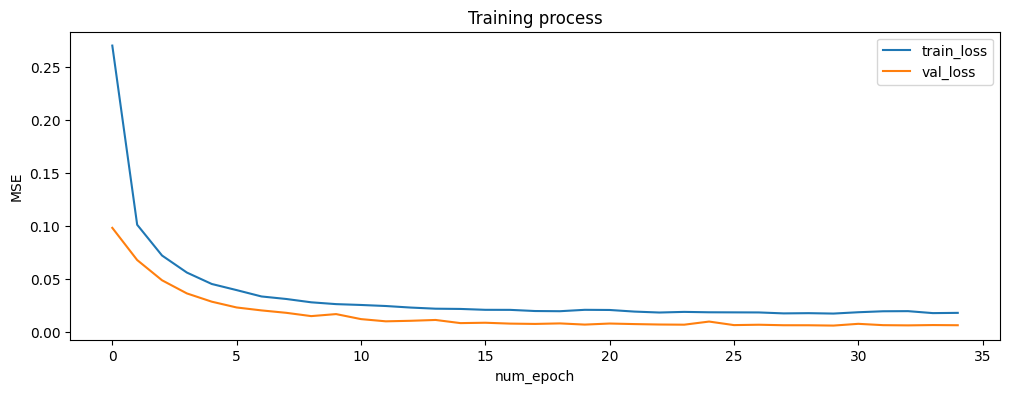

In [16]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [17]:
results = lstm_model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0944
Test Loss: 0.009941388852894306
Test RMSE: 0.09440857917070389


In [18]:
# คำนวณ predicted values
yhat_train = lstm_model.predict(train_X)
yhat_val = lstm_model.predict(val_X)
yhat_test = lstm_model.predict(test_X)


2024-12-22 23:36:36.622465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:36:36.625704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:36:36.627959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step


In [19]:
# คำนวณ residuals
resid_train = train_y - yhat_train
resid_val = val_y - yhat_val
resid_test = test_y - yhat_test

In [20]:
# เตรียมข้อมูล train สำหรับ residual GRU
train_X_resid = train_X.copy()
train_y_resid = resid_train.copy()
val_X_resid = val_X.copy()
val_y_resid = resid_val.copy()
test_X_resid = test_X.copy()
test_y_resid = resid_test.copy()

In [21]:
print(train_X_resid.shape)
print(train_y_resid.shape)
print(val_X_resid.shape)
print(val_y_resid.shape)
print(test_X_resid.shape)
print(test_y_resid.shape)

(816, 1, 80)
(816, 30)
(175, 1, 80)
(175, 30)
(175, 1, 80)
(175, 30)


In [22]:
def create_gru_model(gru_units_1, beta_1,LR,L2):
    model = Sequential()
    model.add(GRU(gru_units_1,activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune lstm
param_dist_gru = {
    'gru_units_1': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2':[0.001,0.005,0.01,0.05,0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
gru_model = KerasRegressor(build_fn=create_gru_model, epochs=100, batch_size=64, verbose=0)

start_time = time.time()

gru_random_search = RandomizedSearchCV(estimator=gru_model, param_distributions=param_dist_gru,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
gru_random_search_result = gru_random_search.fit(train_X_resid, train_y_resid, validation_data=(val_X_resid, val_y_resid), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/tmp/ipykernel_2336285/1859486926.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_model = KerasRegressor(build_fn=create_gru_model, epochs=100, batch_size=64, verbose=0)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024-12-22 23:38:08.346512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:38:08.348392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:38:08.349552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Execution time: 92.32041096687317 seconds


In [23]:
# Get the best parameters and the best score
gru_best_params = gru_random_search_result.best_params_
gru_best_score = -gru_random_search_result.best_score_


In [24]:
print("Best Parameters:", gru_best_params)
print("Best RMSE Score:", gru_best_score)

Best Parameters: {'gru_units_1': 17, 'beta_1': 0.8, 'LR': 0.08800000000000001, 'L2': 0.05}
Best RMSE Score: 0.11210100461754063


In [25]:
gru_model = create_gru_model(gru_units_1=17 ,beta_1=0.8 , LR=0.088, L2=0.05)
gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 17)                5049      
                                                                 
 dropout_5 (Dropout)         (None, 17)                0         
                                                                 
 dense_5 (Dense)             (None, 30)                540       
                                                                 
Total params: 5,589
Trainable params: 5,589
Non-trainable params: 0
_________________________________________________________________


2024-12-22 23:57:12.948881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:57:12.950907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:57:12.952131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [26]:
history_resid = gru_model.fit(train_X_resid, train_y_resid, epochs=150, batch_size=64, validation_data=(val_X_resid, val_y_resid),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150


2024-12-22 23:57:15.404457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:57:15.406625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:57:15.408166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/13 [=>............................] - ETA: 24s - loss: 3.2498 - root_mean_squared_error: 0.3371

2024-12-22 23:57:17.577011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:57:17.579321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:57:17.581000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 3s 45ms/step - loss: 0.7257 - root_mean_squared_error: 0.2370 - val_loss: 0.1064 - val_root_mean_squared_error: 0.0956
Epoch 2/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0556 - root_mean_squared_error: 0.1344 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0722
Epoch 3/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0176 - root_mean_squared_error: 0.1223 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0693
Epoch 4/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0150 - root_mean_squared_error: 0.1212 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0688
Epoch 5/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0148 - root_mean_squared_error: 0.1209 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0701
Epoch 6/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0148 - root_mean_squared_error: 0.1209 - val_loss: 0.0049 - val_root_mean_squared

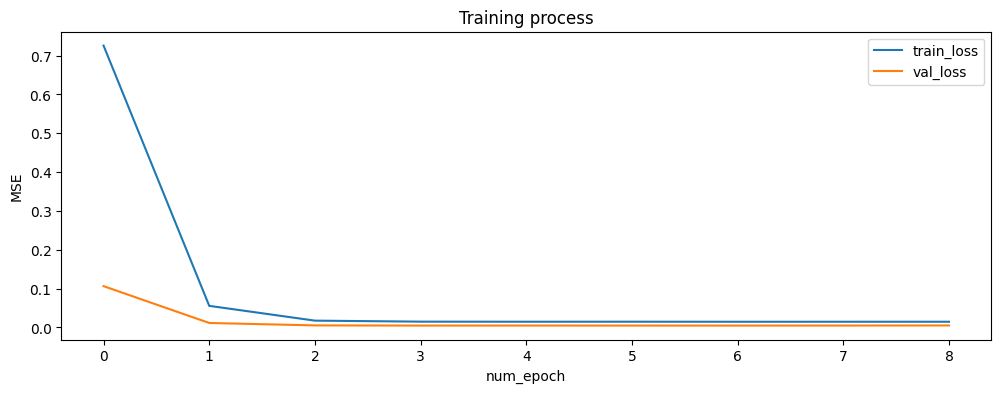

In [27]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history_resid.history['loss'], label='train_loss')
plt.plot(history_resid.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [28]:
results = gru_model.evaluate(test_X_resid, test_y_resid)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0092 - root_mean_squared_error: 0.0953
Test Loss: 0.009193419478833675
Test RMSE: 0.0952741950750351


In [29]:
# คำนวณ predicted residuals
yhat_train_resid = gru_model.predict(train_X_resid)
yhat_val_resid = gru_model.predict(val_X_resid)
yhat_test_resid = gru_model.predict(test_X_resid)

26/26 [==============================] - 0s 1ms/step


2024-12-22 23:57:22.310610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-22 23:57:22.312674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-22 23:57:22.314150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 1ms/step


In [30]:
# Final predicted value = LSTM predicted value + GRU predicted residuals
final_yhat_train = yhat_train + yhat_train_resid
final_yhat_val = yhat_val + yhat_val_resid
final_yhat_test = yhat_test + yhat_test_resid


In [31]:
# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = final_yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = final_yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = final_yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


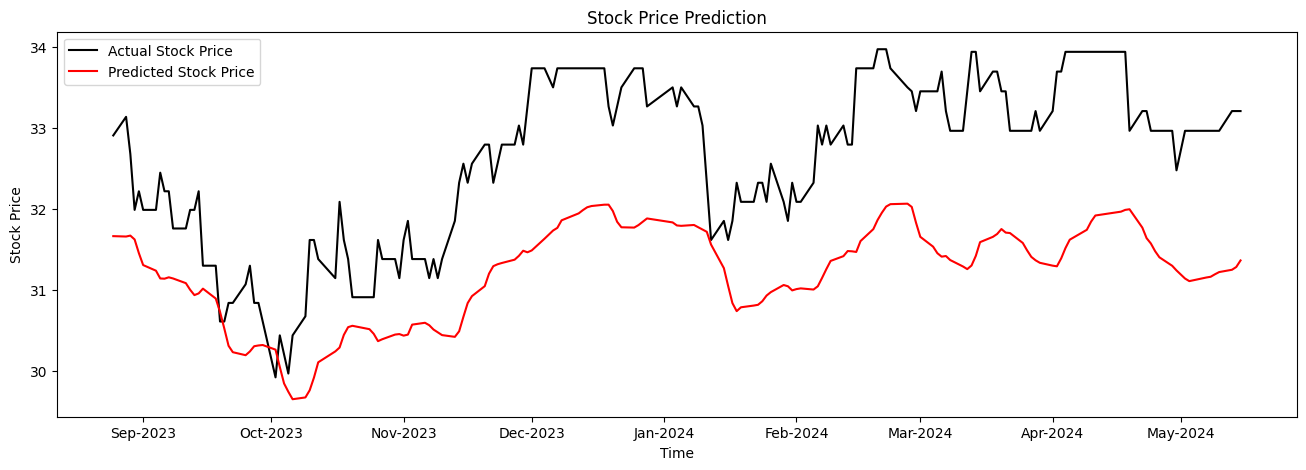

In [32]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

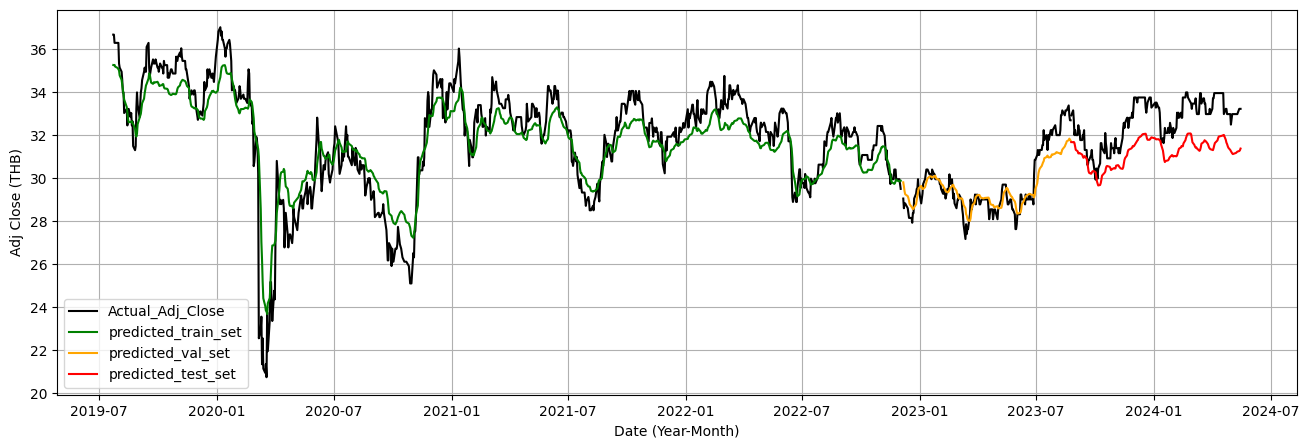

In [33]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


MAPE: 4.3489%
RMSE: 1.6463
